In [5]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from scipy import stats
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import warnings
warnings.filterwarnings('ignore')

In [7]:
# Set style for better visualizations
plt.style.use('default')  # Using default style instead of seaborn
sns.set_theme()  # This will apply seaborn's styling

# Load the data
df = pd.read_csv('delhivery_data.csv')

# Display basic information about the dataset
print("Dataset Shape:", df.shape)
print("\nDataset Info:")
print(df.info())



Dataset Shape: (144867, 24)

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144867 entries, 0 to 144866
Data columns (total 24 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   data                            144867 non-null  object 
 1   trip_creation_time              144867 non-null  object 
 2   route_schedule_uuid             144867 non-null  object 
 3   route_type                      144867 non-null  object 
 4   trip_uuid                       144867 non-null  object 
 5   source_center                   144867 non-null  object 
 6   source_name                     144574 non-null  object 
 7   destination_center              144867 non-null  object 
 8   destination_name                144606 non-null  object 
 9   od_start_time                   144867 non-null  object 
 10  od_end_time                     144867 non-null  object 
 11  start_scan_to_end_scan          144

In [9]:
print("\nMissing Values:")
print(df.isnull().sum())



Missing Values:
data                                0
trip_creation_time                  0
route_schedule_uuid                 0
route_type                          0
trip_uuid                           0
source_center                       0
source_name                       293
destination_center                  0
destination_name                  261
od_start_time                       0
od_end_time                         0
start_scan_to_end_scan              0
is_cutoff                           0
cutoff_factor                       0
cutoff_timestamp                    0
actual_distance_to_destination      0
actual_time                         0
osrm_time                           0
osrm_distance                       0
factor                              0
segment_actual_time                 0
segment_osrm_time                   0
segment_osrm_distance               0
segment_factor                      0
dtype: int64


In [10]:

print("\nBasic Statistics:")
print(df.describe())


Basic Statistics:
       start_scan_to_end_scan  cutoff_factor  actual_distance_to_destination  \
count           144867.000000  144867.000000                   144867.000000   
mean               961.262986     232.926567                      234.073372   
std               1037.012769     344.755577                      344.990009   
min                 20.000000       9.000000                        9.000045   
25%                161.000000      22.000000                       23.355874   
50%                449.000000      66.000000                       66.126571   
75%               1634.000000     286.000000                      286.708875   
max               7898.000000    1927.000000                     1927.447705   

         actual_time      osrm_time  osrm_distance         factor  \
count  144867.000000  144867.000000  144867.000000  144867.000000   
mean      416.927527     213.868272     284.771297       2.120107   
std       598.103621     308.011085     421.119294   

In [13]:
# Function to analyze missing values
def analyze_missing_values(df):
    missing_df = pd.DataFrame({
        'missing_count': df.isnull().sum(),
        'missing_percentage': (df.isnull().sum() / len(df) * 100).round(2)
    })
    return missing_df[missing_df['missing_count'] > 0].sort_values('missing_percentage', ascending=False)


In [15]:
# Analyze missing values
missing_analysis = analyze_missing_values(df)
print("\nMissing Value Analysis:")
print(missing_analysis)

# Convert timestamp columns to datetime with proper format
timestamp_columns = ['trip_creation_time', 'od_start_time', 'od_end_time', 'cutoff_timestamp']
for col in timestamp_columns:
    try:
        # First try with the default format
        df[col] = pd.to_datetime(df[col])
    except ValueError:
        try:
            # If that fails, try with mixed format
            df[col] = pd.to_datetime(df[col], format='mixed')
        except ValueError:
            # If that also fails, try with ISO8601 format
            df[col] = pd.to_datetime(df[col], format='ISO8601')


Missing Value Analysis:
                  missing_count  missing_percentage
source_name                 293                0.20
destination_name            261                0.18


Extract features from trip_creation_time

In [16]:
df['creation_year'] = df['trip_creation_time'].dt.year
df['creation_month'] = df['trip_creation_time'].dt.month
df['creation_day'] = df['trip_creation_time'].dt.day
df['creation_hour'] = df['trip_creation_time'].dt.hour
df['creation_dayofweek'] = df['trip_creation_time'].dt.dayofweek

 Extract location features from source and destination names

In [17]:
def extract_location_features(name):
    if pd.isna(name):  # Handle NaN values
        return pd.Series({'city': np.nan, 'place': np.nan, 'code': np.nan})
    
    if not isinstance(name, str):  # Handle non-string values
        return pd.Series({'city': str(name), 'place': '', 'code': ''})
    
    parts = name.split('-')
    if len(parts) >= 3:
        return pd.Series({
            'city': parts[0].strip(),
            'place': parts[1].strip(),
            'code': parts[2].strip()
        })
    return pd.Series({'city': name, 'place': '', 'code': ''})

# Apply to source and destination names
source_features = df['source_name'].apply(extract_location_features)
destination_features = df['destination_name'].apply(extract_location_features)

In [19]:
# Add new columns
df['source_city'] = source_features['city']
df['source_place'] = source_features['place']
df['source_code'] = source_features['code']

df['destination_city'] = destination_features['city']
df['destination_place'] = destination_features['place']
df['destination_code'] = destination_features['code']

In [21]:
# Display sample of new features
print("\nSample of extracted features:")
df[['source_name', 'source_city', 'source_place', 'source_code',
          'destination_name', 'destination_city', 'destination_place', 'destination_code']].head()


Sample of extracted features:


,source_name,source_city,source_place,source_code,destination_name,destination_city,destination_place,destination_code
0,Anand_VUNagar_DC (Gujarat),Anand_VUNagar_DC (Gujarat),,,Khambhat_MotvdDPP_D (Gujarat),Khambhat_MotvdDPP_D (Gujarat),,
1,Anand_VUNagar_DC (Gujarat),Anand_VUNagar_DC (Gujarat),,,Khambhat_MotvdDPP_D (Gujarat),Khambhat_MotvdDPP_D (Gujarat),,
2,Anand_VUNagar_DC (Gujarat),Anand_VUNagar_DC (Gujarat),,,Khambhat_MotvdDPP_D (Gujarat),Khambhat_MotvdDPP_D (Gujarat),,
3,Anand_VUNagar_DC (Gujarat),Anand_VUNagar_DC (Gujarat),,,Khambhat_MotvdDPP_D (Gujarat),Khambhat_MotvdDPP_D (Gujarat),,
4,Anand_VUNagar_DC (Gujarat),Anand_VUNagar_DC (Gujarat),,,Khambhat_MotvdDPP_D (Gujarat),Khambhat_MotvdDPP_D (Gujarat),,


In [23]:
# Define aggregation functions for different columns
agg_dict = {
    'actual_distance_to_destination': 'sum',
    'actual_time': 'sum',
    'osrm_time': 'sum',
    'osrm_distance': 'sum',
    'segment_actual_time': 'sum',
    'segment_osrm_time': 'sum',
    'segment_osrm_distance': 'sum',
    'route_type': 'first',
    'source_center': 'first',
    'source_name': 'first',
    'destination_center': 'last',
    'destination_name': 'last',
    'od_start_time': 'first',
    'od_end_time': 'last',
    'trip_creation_time': 'first'
}


In [24]:
# Group by trip_uuid and aggregate
df_aggregated = df.groupby('trip_uuid').agg(agg_dict).reset_index()

# Calculate additional time-based features
df_aggregated['total_trip_time'] = (df_aggregated['od_end_time'] - df_aggregated['od_start_time']).dt.total_seconds() / 3600
df_aggregated['creation_to_start_time'] = (df_aggregated['od_start_time'] - df_aggregated['trip_creation_time']).dt.total_seconds() / 3600

# Display sample of aggregated data
print("\nSample of aggregated data:")
df_aggregated.head()


Sample of aggregated data:


,trip_uuid,actual_distance_to_destination,actual_time,osrm_time,osrm_distance,segment_actual_time,segment_osrm_time,segment_osrm_distance,route_type,source_center,source_name,destination_center,destination_name,od_start_time,od_end_time,trip_creation_time,total_trip_time,creation_to_start_time
0,trip-153671041653548748,8860.812105,15682.0,7787.0,10577.7647,1548.0,1008.0,1320.4733,FTL,IND462022AAA,Bhopal_Trnsport_H (Madhya Pradesh),IND000000ACB,Gurgaon_Bilaspur_HB (Haryana),2018-09-12 00:00:16.535741,2018-09-13 13:40:23.123744,2018-09-12 00:00:16.535741,37.668497,0.0
1,trip-153671042288605164,240.208306,399.0,210.0,269.4308,141.0,65.0,84.1894,Carting,IND572101AAA,Tumkur_Veersagr_I (Karnataka),IND562101AAA,Chikblapur_ShntiSgr_D (Karnataka),2018-09-12 00:00:22.886430,2018-09-12 03:01:59.598855,2018-09-12 00:00:22.886430,3.026865,0.0
2,trip-153671043369099517,68163.502238,112225.0,65768.0,89447.2488,3308.0,1941.0,2545.2678,FTL,IND562132AAA,Bangalore_Nelmngla_H (Karnataka),IND160002AAC,Chandigarh_Mehmdpur_H (Punjab),2018-09-12 00:00:33.691250,2018-09-14 17:34:55.442454,2018-09-12 00:00:33.691250,65.572709,0.0
3,trip-153671046011330457,28.529648,82.0,24.0,31.6475,59.0,16.0,19.8766,Carting,IND400072AAB,Mumbai Hub (Maharashtra),IND401104AAA,Mumbai_MiraRd_IP (Maharashtra),2018-09-12 00:01:00.113710,2018-09-12 01:41:29.809822,2018-09-12 00:01:00.113710,1.674916,0.0
4,trip-153671052974046625,239.007304,556.0,207.0,266.2914,340.0,115.0,146.7919,FTL,IND583101AAA,Bellary_Dc (Karnataka),IND583101AAA,Bellary_Dc (Karnataka),2018-09-12 00:02:09.740725,2018-09-12 12:00:30.683231,2018-09-12 00:02:09.740725,11.972484,0.0


In [25]:
print("\nShape of original data:", df.shape)
print("Shape of aggregated data:", df_aggregated.shape)


Shape of original data: (144867, 35)
Shape of aggregated data: (14817, 18)


Starting analysis...

1. Analyzing time and distance metrics...


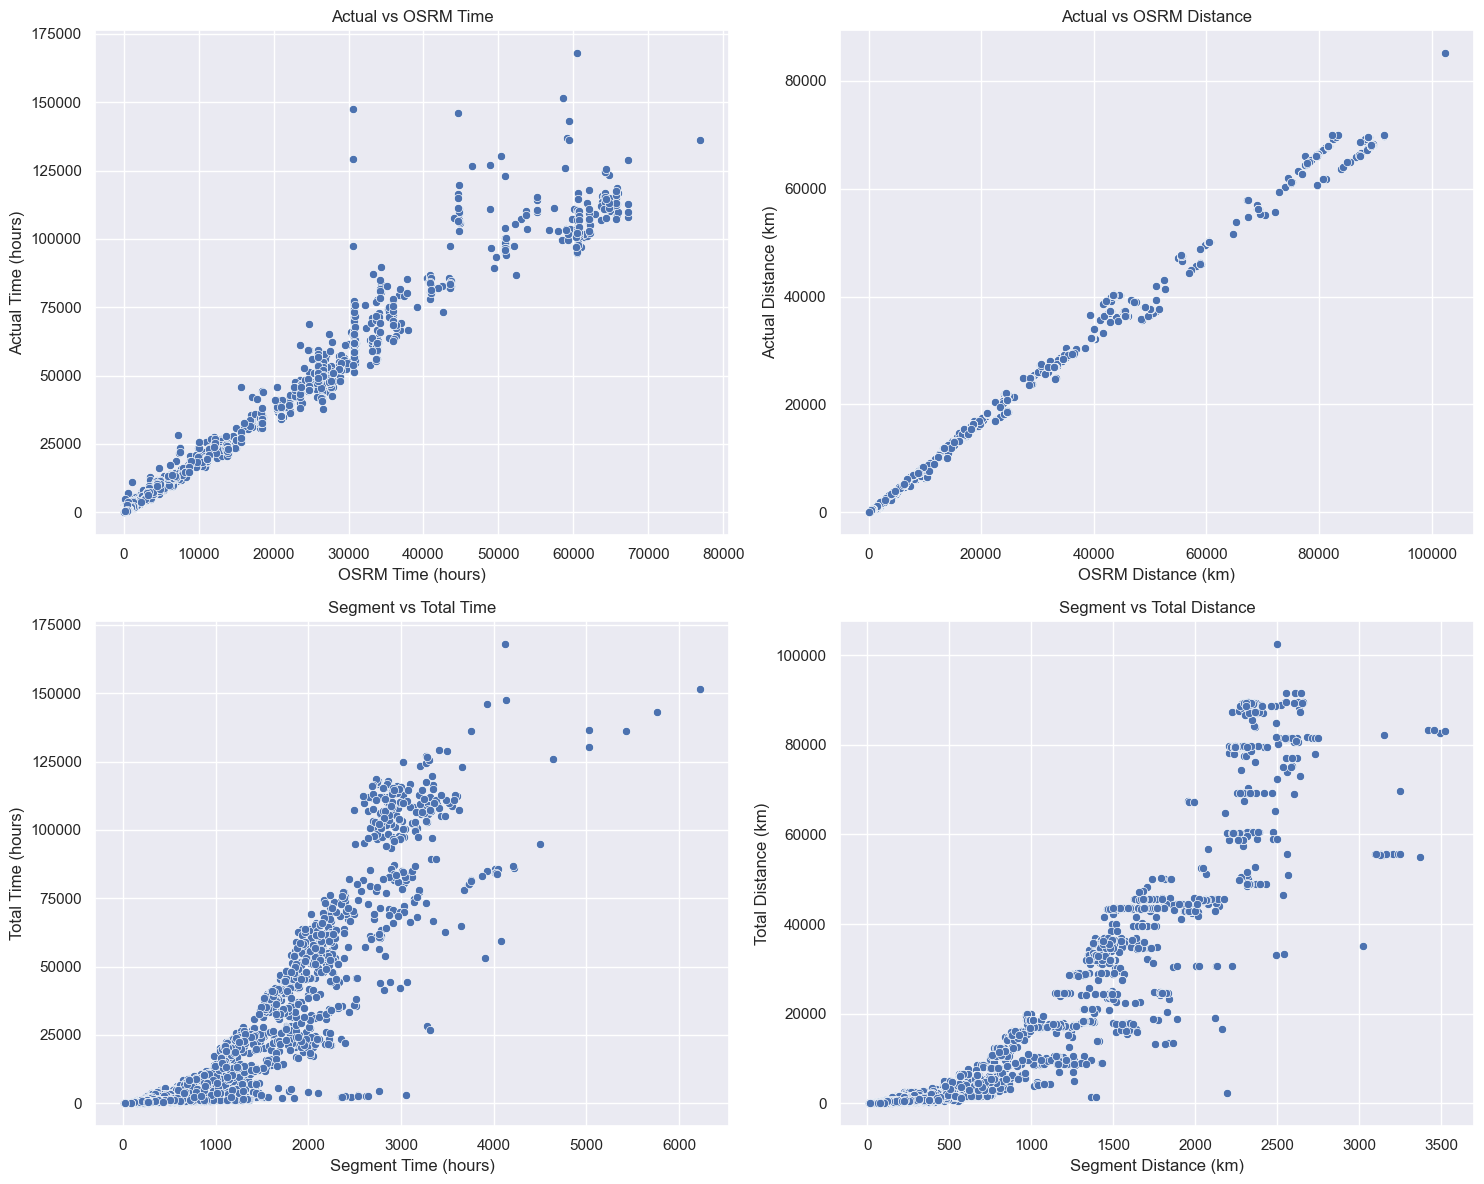


2. Analyzing route types...


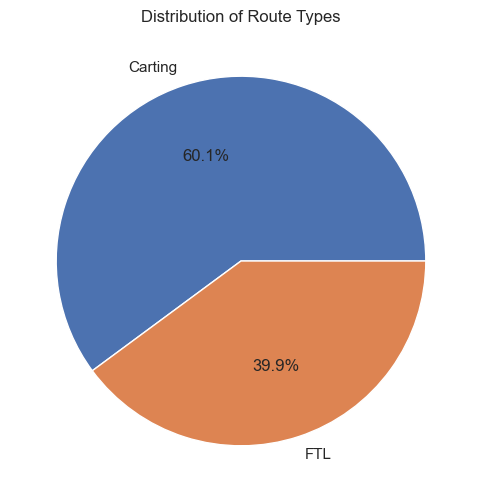


Average Metrics by Route Type:
            actual_time  actual_distance_to_destination  total_trip_time
route_type                                                              
Carting          358.48                          135.08             4.23
FTL             9681.11                         5534.98            16.51

3. Analyzing outliers...


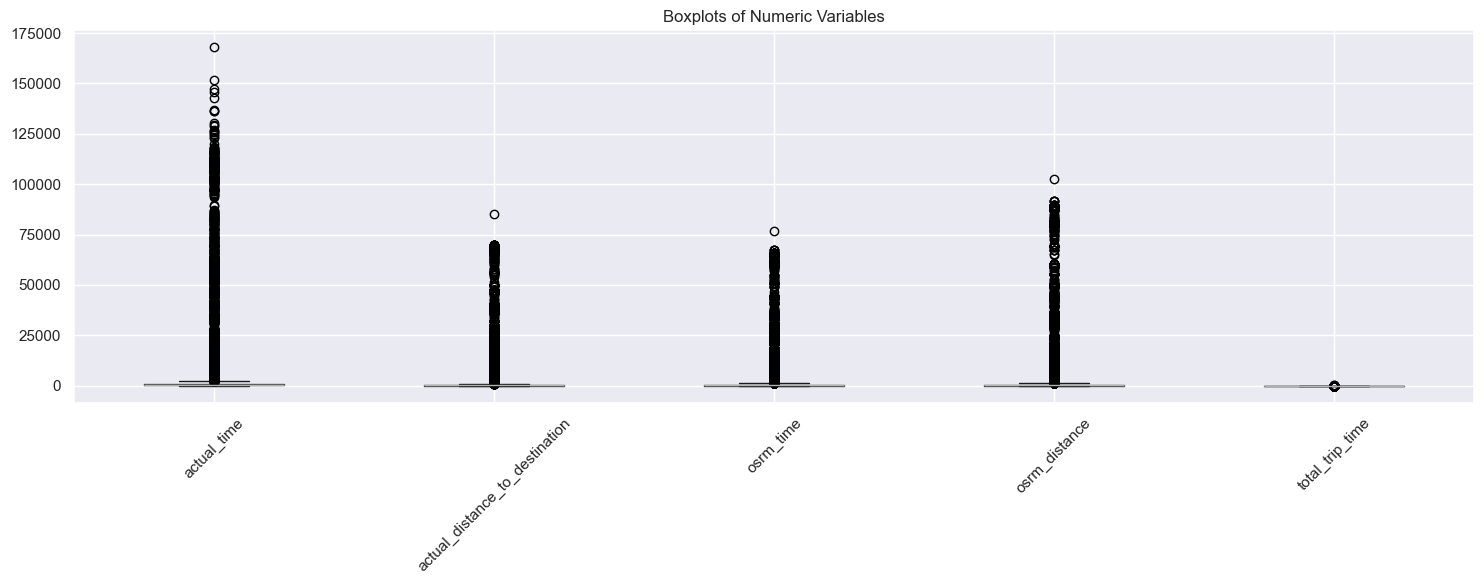


Outliers in actual_time:
Number of outliers: 2070
Percentage of outliers: 13.97%

Outliers in actual_distance_to_destination:
Number of outliers: 2122
Percentage of outliers: 14.32%

Outliers in osrm_time:
Number of outliers: 1948
Percentage of outliers: 13.15%

Outliers in osrm_distance:
Number of outliers: 2069
Percentage of outliers: 13.96%

Outliers in total_trip_time:
Number of outliers: 1115
Percentage of outliers: 7.53%

4. Analyzing corridors...

Top 10 Busiest Corridors:
                                                    number_of_trips  avg_time  \
corridor                                                                        
Chandigarh_Mehmdpur_H (Punjab) - Chandigarh_Meh...              175   1813.45   
Bangalore_Nelmngla_H (Karnataka) - Bengaluru_KG...              151    225.22   
Muzaffrpur_Bbganj_I (Bihar) - Muzaffrpur_Bbganj...              130   1679.89   
Bengaluru_Bomsndra_HB (Karnataka) - Bengaluru_K...              121    332.02   
Bhiwandi_Mankoli_HB (Maharas

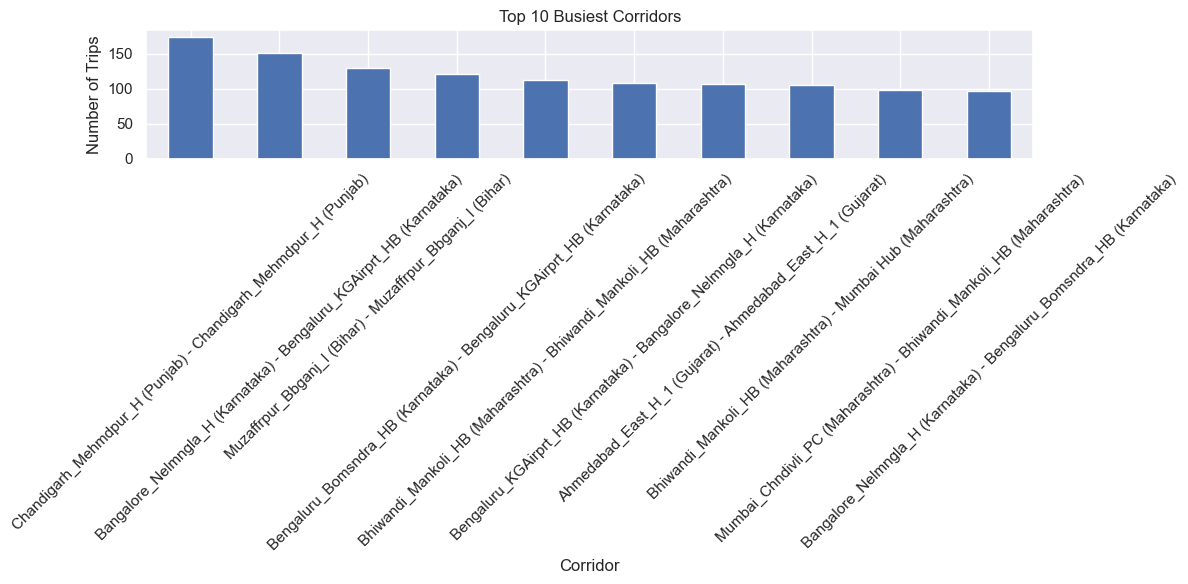


Analysis complete!


In [ ]:
# Set style for better visualizations
plt.style.use('default')  # Using default style instead of seaborn
sns.set_theme()  # This will apply seaborn's styling

# Load the processed data
df = pd.read_csv('processed_delhivery_data.csv')

# 1. Time and Distance Analysis
def analyze_time_distance_metrics(df):
    # Create figure with subplots
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # Plot 1: Actual vs OSRM Time
    sns.scatterplot(data=df, x='osrm_time', y='actual_time', ax=axes[0,0])
    axes[0,0].set_title('Actual vs OSRM Time')
    axes[0,0].set_xlabel('OSRM Time (hours)')
    axes[0,0].set_ylabel('Actual Time (hours)')
    
    # Plot 2: Actual vs OSRM Distance
    sns.scatterplot(data=df, x='osrm_distance', y='actual_distance_to_destination', ax=axes[0,1])
    axes[0,1].set_title('Actual vs OSRM Distance')
    axes[0,1].set_xlabel('OSRM Distance (km)')
    axes[0,1].set_ylabel('Actual Distance (km)')
    
    # Plot 3: Segment vs Total Time
    sns.scatterplot(data=df, x='segment_actual_time', y='actual_time', ax=axes[1,0])
    axes[1,0].set_title('Segment vs Total Time')
    axes[1,0].set_xlabel('Segment Time (hours)')
    axes[1,0].set_ylabel('Total Time (hours)')
    
    # Plot 4: Segment vs Total Distance
    sns.scatterplot(data=df, x='segment_osrm_distance', y='osrm_distance', ax=axes[1,1])
    axes[1,1].set_title('Segment vs Total Distance')
    axes[1,1].set_xlabel('Segment Distance (km)')
    axes[1,1].set_ylabel('Total Distance (km)')
    
    plt.tight_layout()
    plt.show()

# 2. Route Type Analysis
def analyze_route_types(df):
    # Count route types
    route_counts = df['route_type'].value_counts()
    
    # Create pie chart
    plt.figure(figsize=(10, 6))
    plt.pie(route_counts, labels=route_counts.index, autopct='%1.1f%%')
    plt.title('Distribution of Route Types')
    plt.show()
    
    # Calculate average metrics by route type
    route_metrics = df.groupby('route_type').agg({
        'actual_time': 'mean',
        'actual_distance_to_destination': 'mean',
        'total_trip_time': 'mean'
    }).round(2)
    
    print("\nAverage Metrics by Route Type:")
    print(route_metrics)

# 3. Outlier Analysis
def analyze_outliers(df):
    # Select numeric columns for outlier analysis
    numeric_cols = ['actual_time', 'actual_distance_to_destination', 
                   'osrm_time', 'osrm_distance', 'total_trip_time']
    
    # Create boxplots
    plt.figure(figsize=(15, 6))
    df[numeric_cols].boxplot()
    plt.title('Boxplots of Numeric Variables')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    # Calculate IQR and identify outliers
    for col in numeric_cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)][col]
        print(f"\nOutliers in {col}:")
        print(f"Number of outliers: {len(outliers)}")
        print(f"Percentage of outliers: {(len(outliers)/len(df)*100):.2f}%")

# 4. Corridor Analysis
def analyze_corridors(df):
    # Create corridor identifier
    df['corridor'] = df['source_city'] + ' - ' + df['destination_city']
    
    # Analyze top corridors
    corridor_metrics = df.groupby('corridor').agg({
        'trip_uuid': 'count',
        'actual_time': 'mean',
        'actual_distance_to_destination': 'mean',
        'total_trip_time': 'mean'
    }).round(2)
    
    corridor_metrics.columns = ['number_of_trips', 'avg_time', 'avg_distance', 'avg_total_time']
    corridor_metrics = corridor_metrics.sort_values('number_of_trips', ascending=False)
    
    print("\nTop 10 Busiest Corridors:")
    print(corridor_metrics.head(10))
    
    # Visualize top corridors
    plt.figure(figsize=(12, 6))
    corridor_metrics.head(10)['number_of_trips'].plot(kind='bar')
    plt.title('Top 10 Busiest Corridors')
    plt.xlabel('Corridor')
    plt.ylabel('Number of Trips')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()



analyze_time_distance_metrics(df)

analyze_route_types(df)


analyze_outliers(df)

analyze_corridors(df)
